In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

current_working_dir = os.getcwd()
if os.path.basename(current_working_dir) == 'notebooks':
    project_root_dir = os.path.abspath(os.path.join(current_working_dir, '..'))
else:
    project_root_dir = current_working_dir

src_path = os.path.join(project_root_dir, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from data_processing import get_data_processing_pipeline, generate_proxy_target
from model_training import train_and_log_model

print("Setup complete for Model Evaluation and Interpretation notebook.")


Setup complete for Model Evaluation and Interpretation notebook.


In [2]:
print("Loading and processing data...")

current_working_dir = os.getcwd()
if os.path.basename(current_working_dir) == 'notebooks':
    project_root_dir = os.path.abspath(os.path.join(current_working_dir, '..'))
else:
    project_root_dir = current_working_dir

raw_data_file_path = os.path.join(project_root_dir, 'data', 'raw', 'data.csv')

raw_df = None
try:
    raw_df = pd.read_csv(raw_data_file_path)
    print(f"Raw data loaded successfully from: {raw_data_file_path}")
except FileNotFoundError:
    print(f"Error: Data file not found at {raw_data_file_path}. Please ensure it exists.")
    raise
except Exception as e:
    print(f"An unexpected error occurred while loading data: {e}")
    raise

if raw_df is None:
    raise ValueError("raw_df could not be loaded. Aborting data processing.")

pipeline = get_data_processing_pipeline()
processed_data_array = pipeline.fit_transform(raw_df.copy())

preprocessor_step = pipeline.named_steps['preprocessor']
num_features_out = preprocessor_step.named_transformers_['num'].get_feature_names_out()
cat_features_out = preprocessor_step.named_transformers_['cat'].get_feature_names_out()

df_before_preprocessor = pipeline.named_steps['datetime_extractor'].transform(raw_df.copy())
df_before_preprocessor = pipeline.named_steps['amount_handler'].transform(df_before_preprocessor)
processed_by_preprocessor = ['Amount', 'Value', 'PricingStrategy',
                             'ProductCategory', 'ChannelId', 'ProviderId', 'ProductId']
passthrough_cols_final = [col for col in df_before_preprocessor.columns if col not in processed_by_preprocessor]
final_feature_names = list(num_features_out) + list(cat_features_out) + passthrough_cols_final

processed_df = pd.DataFrame(processed_data_array, columns=final_feature_names)

numeric_cols_to_convert = list(num_features_out) + \
                          list(cat_features_out) + \
                          ['transaction_hour', 'transaction_day_of_week', 'transaction_month',
                           'transaction_year', 'is_refund', 'FraudResult']

for col in numeric_cols_to_convert:
    if col in processed_df.columns:
        processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')

proxy_target_df = generate_proxy_target(raw_df.copy())
proxy_target_df_reset = proxy_target_df.reset_index()

final_processed_df = pd.merge(
    processed_df,
    proxy_target_df_reset[['CustomerId', 'is_high_risk']],
    on='CustomerId',
    how='left'
)

X = final_processed_df.drop(columns=[
    'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
    'CurrencyCode', 'CountryCode', 'TransactionStartTime', 'FraudResult',
    'is_high_risk'
])
y = final_processed_df['is_high_risk']

initial_rows = X.shape[0]
X = X.dropna(axis=1)
X = X.dropna(axis=0)
rows_after_na = X.shape[0]
if initial_rows != rows_after_na:
    print(f"Dropped {initial_rows - rows_after_na} rows due to NaN values after processing.")

y = y.loc[X.index]

print(f"Features shape: {X.shape}, Target shape: {y.shape}")
print(f"Target distribution (is_high_risk):\\n{y.value_counts(normalize=True)}")

test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

print("Data loading and processing complete. Data split into training and testing sets.")


Loading and processing data...
Raw data loaded successfully from: /home/y/Credit Risk Probability/credit-risk-model/data/raw/data.csv

RFM Cluster Means (Scaled):
         Recency_Scaled  Frequency_Scaled  Monetary_Scaled
Cluster                                                   
0              0.443276          0.004167         0.002551
1              0.080559          0.008996         0.002899
2              0.808647          0.001454         0.001040

Identified high-risk cluster (based on Risk_Score heuristic): 2
Features shape: (95662, 50), Target shape: (95662,)
Target distribution (is_high_risk):\nis_high_risk
0    0.944011
1    0.055989
Name: proportion, dtype: float64
Data loading and processing complete. Data split into training and testing sets.


In [6]:
print("Training and loading the latest model from MLflow...")

current_working_dir = os.getcwd()
if os.path.basename(current_working_dir) == 'notebooks':
    project_root_dir = os.path.abspath(os.path.join(current_working_dir, '..'))
else:
    project_root_dir = current_working_dir

raw_data_file_path_for_training = os.path.join(project_root_dir, 'data', 'raw', 'data.csv')

train_and_log_model(raw_data_file_path_for_training)

mlflow_tracking_uri = os.path.join(project_root_dir, 'notebooks', 'mlruns')
mlflow.set_tracking_uri(f"file://{mlflow_tracking_uri}")

client = mlflow.tracking.MlflowClient()
experiment_name = "Credit_Risk_Model_Training"

try:
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment is None:
        raise ValueError(f"Experiment '{experiment_name}' not found.")

    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"],
        max_results=1
    )

    if not runs:
        raise ValueError(f"No runs found for experiment '{experiment_name}'. Please train a model first.")

    latest_run = runs[0]
    latest_run_id = latest_run.info.run_id
    print(f"Latest MLflow Run ID: {latest_run_id}")

    model_uri = f"runs:/{latest_run_id}/logistic_regression_model"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    print("Model loaded successfully from MLflow.")
    
except Exception as e:
    print(f"Error loading model from MLflow: {e}")
    print("Please ensure you have run the 3.0-model-training.ipynb notebook to log a model.")
    raise

print("Model training and loading complete.")


Training and loading the latest model from MLflow...
Loading data from: /home/y/Credit Risk Probability/credit-risk-model/data/raw/data.csv

RFM Cluster Means (Scaled):
         Recency_Scaled  Frequency_Scaled  Monetary_Scaled
Cluster                                                   
0              0.443276          0.004167         0.002551
1              0.080559          0.008996         0.002899
2              0.808647          0.001454         0.001040

Identified high-risk cluster (based on Risk_Score heuristic): 2
Features shape: (95662, 50), Target shape: (95662,)
Target distribution (is_high_risk):
is_high_risk
0    0.944011
1    0.055989
Name: proportion, dtype: float64
X_train shape: (76529, 50), X_test shape: (19133, 50)
y_train shape: (76529,), y_test shape: (19133,)


2025/07/03 13:21:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.55      0.71     18062
           1       0.11      0.99      0.21      1071

    accuracy                           0.57     19133
   macro avg       0.56      0.77      0.46     19133
weighted avg       0.95      0.57      0.68     19133

ROC AUC Score: 0.7422
PR AUC Score: 0.1353


2025/07/03 13:22:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Run ID: e0629bf19d884cfb8535c204a947ede6
MLflow Tracking URI: file:///home/y/Credit%20Risk%20Probability/credit-risk-model/notebooks/mlruns
Model training and logging complete.
Latest MLflow Run ID: e0629bf19d884cfb8535c204a947ede6
Model loaded successfully from MLflow.
Model training and loading complete.


Evaluating the loaded model...

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.55      0.71     18062
           1       0.11      0.99      0.21      1071

    accuracy                           0.57     19133
   macro avg       0.56      0.77      0.46     19133
weighted avg       0.95      0.57      0.68     19133

ROC AUC Score: 0.7422
PR AUC Score: 0.1353

--- Confusion Matrix ---
[[9931 8131]
 [  16 1055]]


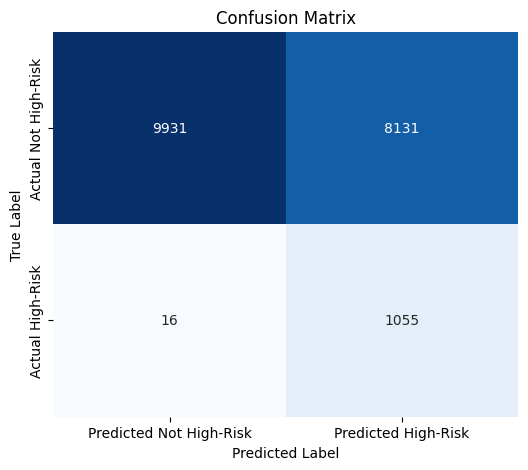

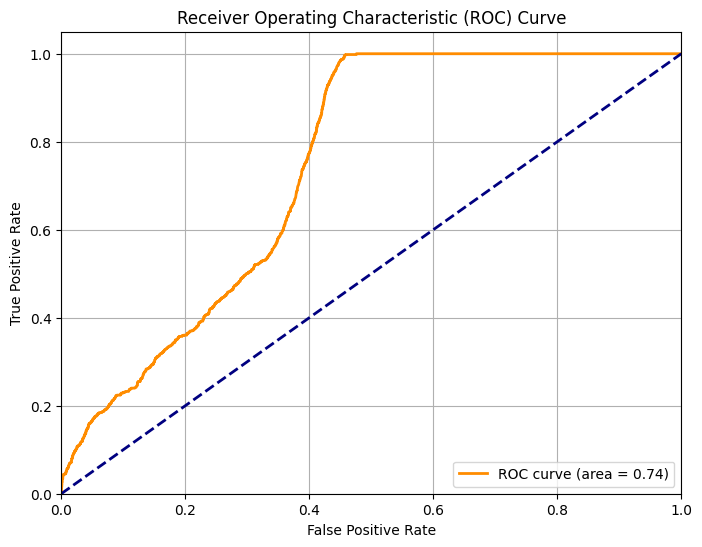

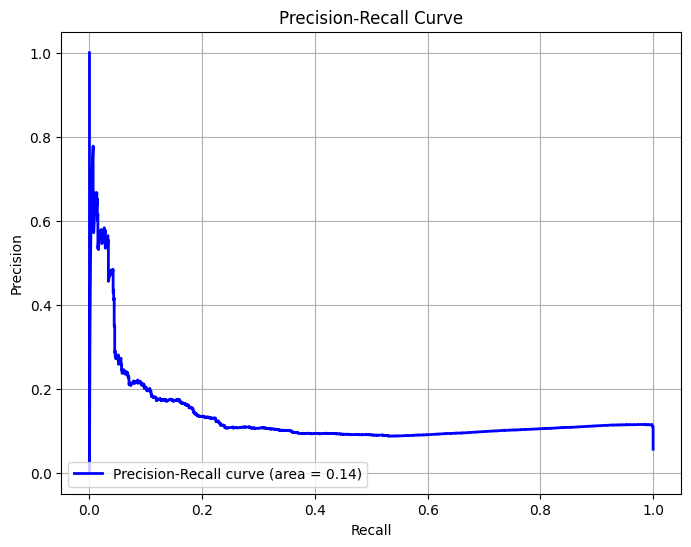

Model evaluation complete.


In [7]:
print("Evaluating the loaded model...")

y_pred = loaded_model.predict(X_test)
y_proba = loaded_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC Score: {pr_auc:.4f}")

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Not High-Risk', 'Predicted High-Risk'],
            yticklabels=['Actual Not High-Risk', 'Actual High-Risk'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print("Model evaluation complete.")


Performing threshold tuning...

Optimal Threshold (maximizing F1-score): 0.5003
Precision at optimal threshold: 0.1148
Recall at optimal threshold: 0.9851
F1-score at optimal threshold: 0.2057


/tmp/ipykernel_30805/3156503090.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


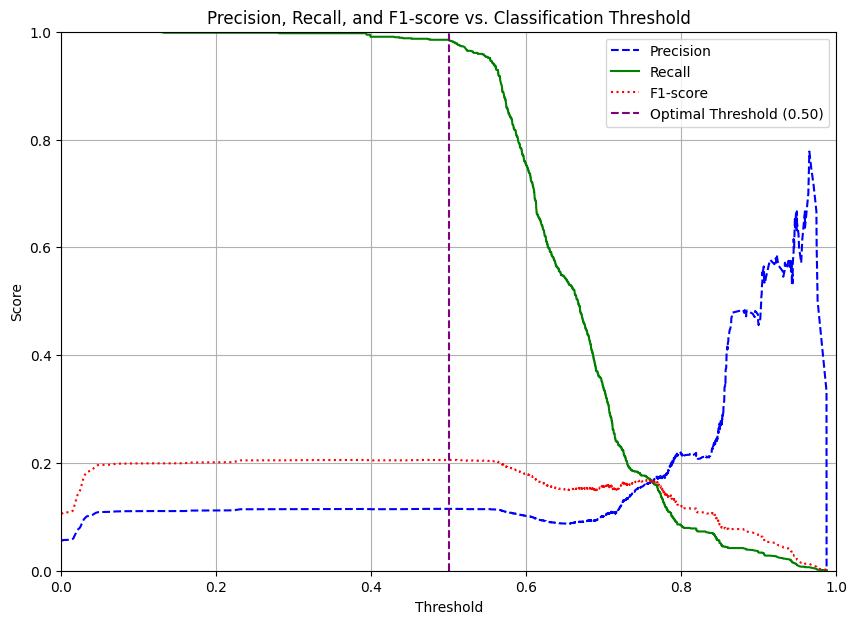


--- Classification Report with Optimal Threshold (0.5003) ---
              precision    recall  f1-score   support

           0       1.00      0.55      0.71     18062
           1       0.11      0.99      0.21      1071

    accuracy                           0.57     19133
   macro avg       0.56      0.77      0.46     19133
weighted avg       0.95      0.57      0.68     19133



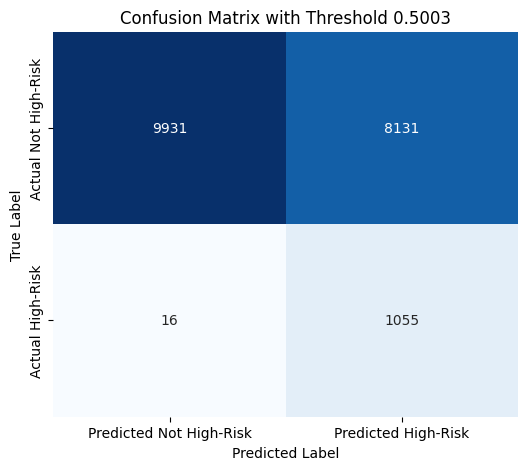

Threshold tuning complete.


In [8]:
print("Performing threshold tuning...")

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores, nan=0.0)

optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
optimal_precision = precisions[optimal_threshold_idx]
optimal_recall = recalls[optimal_threshold_idx]
optimal_f1 = f1_scores[optimal_threshold_idx]

print(f"\nOptimal Threshold (maximizing F1-score): {optimal_threshold:.4f}")
print(f"Precision at optimal threshold: {optimal_precision:.4f}")
print(f"Recall at optimal threshold: {optimal_recall:.4f}")
print(f"F1-score at optimal threshold: {optimal_f1:.4f}")

plt.figure(figsize=(10, 7))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "r:", label="F1-score")
plt.axvline(x=optimal_threshold, color='purple', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score vs. Classification Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

y_pred_optimal_threshold = (y_proba >= optimal_threshold).astype(int)

print(f"\n--- Classification Report with Optimal Threshold ({optimal_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_optimal_threshold))

cm_optimal = confusion_matrix(y_test, y_pred_optimal_threshold)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Not High-Risk', 'Predicted High-Risk'],
            yticklabels=['Actual Not High-Risk', 'Actual High-Risk'])
plt.title(f'Confusion Matrix with Threshold {optimal_threshold:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Threshold tuning complete.")


Interpreting model coefficients...

--- Top 10 Most Impactful Features (by absolute coefficient value) ---
                Feature  Coefficient  Abs_Coefficient
                 Amount     5.102989         5.102989
                  Value    -5.078951         5.078951
  ProductId_ProductId_2    -1.531783         1.531783
 ProductId_ProductId_27    -1.435946         1.435946
  ChannelId_ChannelId_1     1.226500         1.226500
ProviderId_ProviderId_2    -1.048892         1.048892
  ChannelId_ChannelId_3    -0.903464         0.903464
 ProductId_ProductId_11     0.896459         0.896459
 ProductId_ProductId_12     0.877972         0.877972
  ProductCategory_other     0.877972         0.877972

--- Top 10 Features with Positive Coefficients (increasing risk) ---
                Feature  Coefficient  Abs_Coefficient
                 Amount     5.102989         5.102989
  ChannelId_ChannelId_1     1.226500         1.226500
 ProductId_ProductId_11     0.896459         0.896459
 ProductId_Pr

/tmp/ipykernel_30805/3294246064.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), palette='viridis')


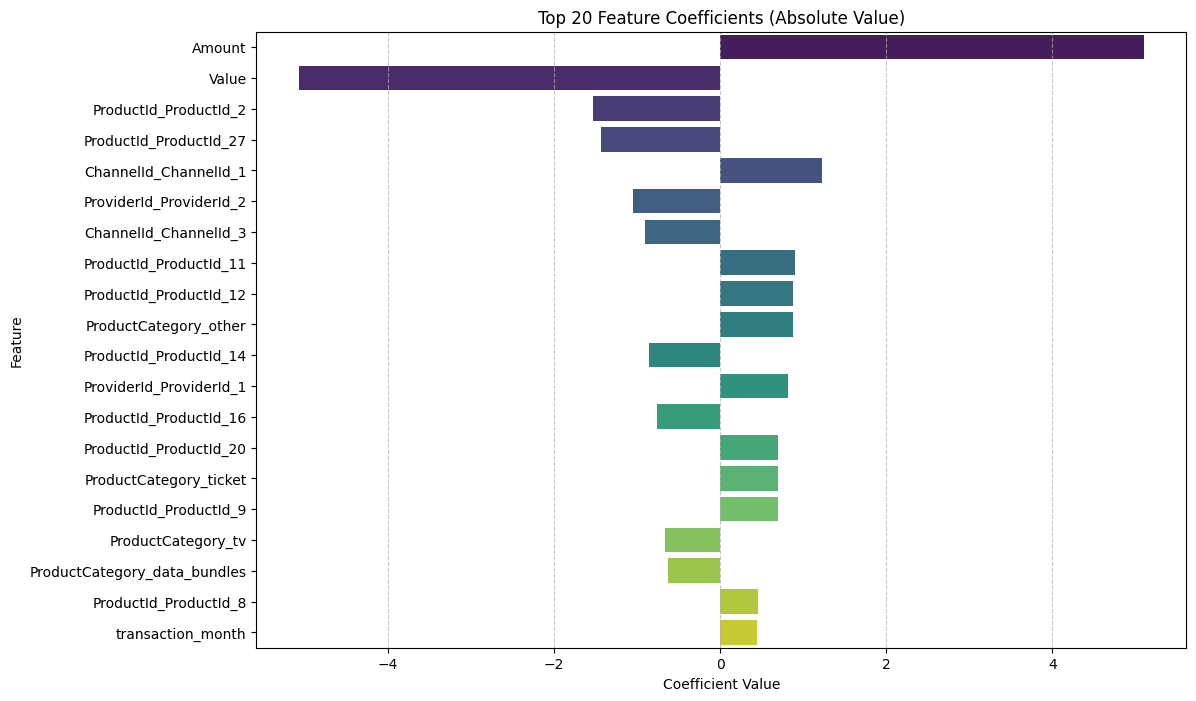

Model interpretation complete.


In [9]:
print("Interpreting model coefficients...")

if hasattr(loaded_model, 'coef_') and hasattr(loaded_model, 'feature_names_in_'):
    coefficients = loaded_model.coef_[0]
    feature_names = loaded_model.feature_names_in_

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

    print("\n--- Top 10 Most Impactful Features (by absolute coefficient value) ---")
    print(coef_df.head(10).to_string(index=False))

    print("\n--- Top 10 Features with Positive Coefficients (increasing risk) ---")
    print(coef_df[coef_df['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(10).to_string(index=False))

    print("\n--- Top 10 Features with Negative Coefficients (decreasing risk) ---")
    print(coef_df[coef_df['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(10).to_string(index=False))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), palette='viridis')
    plt.title('Top 20 Feature Coefficients (Absolute Value)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

else:
    print("Model does not have 'coef_' or 'feature_names_in_' attribute, or is not a LogisticRegression model.")
    print("Cannot perform coefficient interpretation.")

print("Model interpretation complete.")
